# Testing the Approximate Sampling

## Importing the Packages

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

import time

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

## Defining SE Covariance

In [3]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

## Creating Test Data

In [4]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

In [5]:
# Time resolution
time_bin = 0.005

### True Filter

In [6]:
# Predictions
fpredmax = 6.0
sig_true = 0.5
ell_true = 0.6
d = np.floor(fpredmax/time_bin).astype(np.int64)
fpredpoints = np.linspace(0.0, fpredmax, d + 1).reshape((d + 1, 1))


# Use sampled filter to generate inducing points
num_ind = 1000
indices = np.arange(int(1 * (d + 1) / 6), int( 2 * (d + 1) / 6))
subfil = np.asarray(random.choice(subkeys[-2], indices, (num_ind,)))
z_vector = fpredpoints[subfil]
# u_vector = ftrue[subfil]

In [7]:
# Variational posterior
# Variance
vmat = Squared_exp(z_vector, z_vector.T, sig_true / 3.0, ell_true * 0.7)
cholmat = np.linalg.cholesky(vmat + 1e-6 * np.eye(num_ind))
# Mean
m = cholmat @ random.normal(subkeys[-2], (num_ind, 1)) - 1.0

# Mean
kzz = Squared_exp(z_vector, z_vector.T, sig_true, ell_true)
kzast = Squared_exp(z_vector, fpredpoints.T, sig_true, ell_true)
kast = Squared_exp(fpredpoints, fpredpoints.T, sig_true, ell_true)
bmat = sc.linalg.solve(kzz + 1e-6 * np.eye(num_ind), kzast)
bmatt = bmat.T

muast = bmatt @ m
vast = kast - bmatt @ kzast + bmatt @ vmat @ bmat

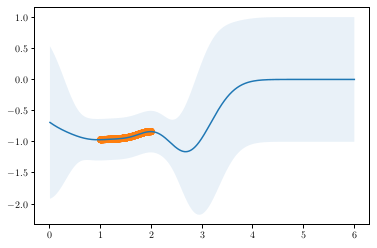

In [8]:
plt.plot(fpredpoints, muast)
s2 = np.sqrt(np.diag(vast))
fill = (muast.flatten() - 2 * s2, muast.flatten() + 2 * s2)
plt.fill_between(fpredpoints.flatten(), *fill, alpha = 0.1)
plt.scatter(z_vector, m)

## Approximate Sampling

In [9]:
@jit
def Solver(Kmm, Diff):
  return jsc.linalg.solve(Kmm, Diff, sym_pos=True, check_finite=True)

In [10]:
V_Solver = vmap(Solver, in_axes = [None, 0])

In [11]:
# @partial(jit, static_argnums = range(5,8))
def Expected_Term(Sigma_f, Ell, Z_Vector, Mu_Vector, V_Ind, Number_F, Num_Base, M, F_Time, Subkeys):

  Thetas = random.multivariate_normal(Subkeys[0], jnp.zeros((Number_F, 1, Num_Base)), (1.0 / (4.0 * jnp.pi ** 2 * Ell ** 2)) * jnp.eye(Num_Base))

  Taus = random.uniform(Subkeys[1], (Number_F, 1, Num_Base)) * 2.0 * jnp.pi

  Omegas = random.normal(Subkeys[2], (Number_F, Num_Base, 1))

  Constant = Sigma_f * jnp.sqrt(2.0 / Num_Base)

  ZT = Z_Vector.T
 
  Phi1 = Constant * jnp.cos(F_Time * Thetas + Taus)
  Phi2 = Constant * jnp.cos(Z_Vector * Thetas + Taus)

  Kmm = Squared_exp(Z_Vector, ZT, Sigma_f, Ell)
  Knm = Squared_exp(F_Time, ZT, Sigma_f, Ell)

  V_uChol = jnp.linalg.cholesky(V_Ind + 1e-6 * jnp.eye(M))
  U_Samples = Mu_Vector + V_uChol @ random.normal(Subkeys[3], (Number_F, M, 1))

  Vu = V_Solver(Kmm + 1e-6 * jnp.eye(M), U_Samples - Phi2 @ Omegas)

  F_Samples = Phi1 @ Omegas + Knm @ Vu
  
  return F_Samples

In [18]:
test_num_f = 100
test_num_b = 1000
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 5)

In [19]:
fsamples = Expected_Term(sig_true, ell_true, z_vector, m, vmat, test_num_f, test_num_b, num_ind, fpredpoints, test_subkeys)
stds = np.std(fsamples, 0)
mean = np.mean(fsamples, 0)

(-2.5, 1.5)

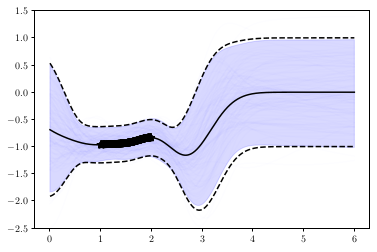

In [20]:
for i in range(test_num_f):
  plt.plot(fpredpoints, fsamples[i], c = 'b', alpha = 0.01)

plt.plot(fpredpoints, muast, c = 'k')
plt.plot(fpredpoints, fill[0], c = 'k', linestyle = '--')
plt.plot(fpredpoints, fill[1], c = 'k', linestyle = '--')
fillemp = (mean.flatten() - 2 * stds.flatten(), mean.flatten() + 2 * stds.flatten())
plt.fill_between(fpredpoints.flatten(), *fillemp, alpha = 0.15, color = 'blue')
plt.scatter(z_vector, m, zorder = 3, color = 'k', marker = '*', s = 50)
plt.ylim([-2.5, 1.5])